In [1]:
import numpy as np
import sympy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import fsolve,root

x = sp.symbols('x')

M_p = 1
b = 2.3e-5

# Definimos el potencial en función de las variables del problema, con x=phi. Lo hago de forma simbólica para luego calcular las derivadas

def potencial(x,kappa,lambda_0,xi):

    return (lambda_0+b*(sp.log((sp.sqrt(xi)/kappa/M_p)*((M_p/sp.sqrt(xi))*sp.sqrt(1-sp.exp(-(sp.sqrt(2/3)/M_p)*x)))))**2)*(((M_p/sp.sqrt(xi))*sp.sqrt(1-sp.exp(-(sp.sqrt(2/3)/M_p)*x)))**4)/4

# Esta función y las siguientes son para calcular phi=phi(N) en función de los parámetros del problema y phi(N=0)
# Lo hago de esta forma y no con la expresión simbólica anterior porque no consigo que funcione bien con odeint

def evol_phi(phi,N,kappa,lambda_0,xi):
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    
    V=potencial(phi[0],kappa,lambda_0,xi)
    Vd=derivada_1.evalf(subs={x: phi[0]})
    
    return sp.sqrt((M_p*Vd/V)**2)

def all_parameters(phi_0,kappa,xi,lambda_0):
    
    if phi_0<0:
        phi_0=-phi_0
        
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    derivada_2 = sp.diff(derivada_1,x)
    
    N=np.linspace(0,60,1000)
    
    #Calculo phi(N)
    
    phi_N=odeint(evol_phi,phi_0,N,args=(kappa,lambda_0,xi))
    #plt.plot(N,phi_N)
    #plt.title("Campo phi en función de N")
    #plt.show()
    
    phi_f=phi_N[-1]
    phi_60=phi_f[0]
    
    V_0=potencial(phi_0,kappa,lambda_0,xi)
    Vd_0=derivada_1.evalf(subs={x: phi_0})
    Vdd_0=derivada_2.evalf(subs={x: phi_0})
    
    V_60=potencial(phi_60,kappa,lambda_0,xi)
    Vd_60=derivada_1.evalf(subs={x: phi_60})
    Vdd_60=derivada_2.evalf(subs={x: phi_60})
    
    eps_v_0=((M_p*Vd_0/V_0)**2)/2
    eta_v_0=M_p**2*Vdd_0/V_0
    eps_0=eps_v_0
    eta_0=4*eps_v_0-2*eta_v_0
    
    eps_v_60=((M_p*Vd_60/V_60)**2)/2
    eta_v_60=M_p**2*Vdd_60/V_60
    eps_60=eps_v_60
    eta_60=4*eps_v_60-2*eta_v_60
    
    P_r=sp.log(V_60/24/sp.pi**2/eps_60/M_p**4*10**10)
    n_s=1-eta_60-2*eps_60
    r=16*eps_60
    
    print("El valor de n_s es ",n_s)
    print("El valor de r es ", r)
    print("La normalización de P_r es", P_r.evalf())
    print("El valor de eps(0) es ", eps_0)
    
    return [eps_0,n_s,r,P_r]

def fit_phi_0_try(phi_0,kappa,xi,lambda_0):
    
    if phi_0<0:
        phi_0=-phi_0
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    
    V_0=potencial(phi_0[0],kappa,lambda_0,xi)
    Vd_0=derivada_1.evalf(subs={x: phi_0[0]}) 
    #print("Nueva iteración para phi_0: ",1-((M_p*Vd_0/V_0)**2)/2, phi_0[0])
    
    return 1-((M_p*Vd_0/V_0)**2)/2

def correct_phi_0_try(kappa,xi,lambda_0):
    
    x_0=0.4 #parámetro inicial de iteración
    
    phi_0=fsolve(fit_phi_0_try,x_0,args=(kappa,xi,lambda_0))
    
    return phi_0[0]

def fit(x_fit,kappa):
    
    xi=x_fit[0]
    lambda_0=x_fit[1]
    
    phi_0=correct_phi_0_try(kappa,xi,lambda_0)
    
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
        
    if phi_0<0:
        phi_0=-phi_0
    
    #Expresión de las derivadas del potencial pero sin evaluar en phi todavía
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    derivada_2 = sp.diff(derivada_1,x)
    
    N=np.linspace(0,60,500)
    
    #Calculo phi(N)
    
    phi_N=odeint(evol_phi,phi_0,N,args=(kappa,lambda_0,xi))
    #plt.plot(phi_N)
    
    phi_f=phi_N[-1]
    phi_60=phi_f[0]
    
    #Obtengo los parámetros del sistema (potencial, eps y eta) para phi(N=0) (_0) y phi(N=60) (_60)
    
    V_0=potencial(phi_0,kappa,lambda_0,xi)
    Vd_0=derivada_1.evalf(subs={x: phi_0})
    Vdd_0=derivada_2.evalf(subs={x: phi_0})
    
    V_60=potencial(phi_60,kappa,lambda_0,xi)
    Vd_60=derivada_1.evalf(subs={x: phi_60})
    Vdd_60=derivada_2.evalf(subs={x: phi_60})
    
    eps_v_0=((M_p*Vd_0/V_0)**2)/2
    eta_v_0=M_p**2*Vdd_0/V_0
    eps_0=eps_v_0
    eta_0=4*eps_v_0-2*eta_v_0
    
    eps_v_60=((M_p*Vd_60/V_60)**2)/2
    eta_v_60=M_p**2*Vdd_60/V_60
    eps_60=eps_v_60
    eta_60=4*eps_v_60-2*eta_v_60
    
    #Para ir viendo como va la iteración
    print('Epsilon: ',eps_0,', n_s: ',1-eta_60-2*eps_60,', P_r:',sp.log(V_60/24/sp.pi**2/eps_60/M_p**4*10**10).evalf())
    #print("Phi_0: ",phi_0,", xi: ",xi,", lambda_0: ",lambda_0)
    
    #Tiene esta estructura porque fsolve resuelve numéricamente la ecuación f(x)=0
    #En orden: n_s=0.986 (en N=60), fijación del power spectrum (en N=60)
    return [0.968-(1-eta_60-2*eps_60),3.094-sp.log(V_60/24/sp.pi**2/eps_60/M_p**4*10**10)]

def power_spectrum_60(phi_0,kappa,xi,lambda_0):
    
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
        
    if phi_0<0:
        phi_0=-phi_0
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    
    N=np.linspace(0,60,1000)
    
    phi_N=odeint(evol_phi,phi_0,N,args=(kappa,lambda_0,xi))

    P_r=[]
    
    for i in range(len(N)):
        value=phi_N[len(N)-i-1]
        V=potencial(value[0],kappa,lambda_0,xi)
        Vd=derivada_1.evalf(subs={x: value[0]})
        eps=((M_p*Vd/V)**2)/2
        P_r.append((V/24/sp.pi**2/eps/M_p**4).evalf())
        
    N_plot=np.linspace(60,0,1000)
    
    plt.plot(N_plot,P_r)
    plt.title("Power Spectrum en función de N")
    plt.yscale("log")
    plt.show()
        
    return P_r

def plot_pot(phi_0,kappa,xi,lambda_0):
    
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
        
    if phi_0<0:
        phi_0=-phi_0
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    
    N=np.linspace(0,60,1000)
    
    phi_N=odeint(evol_phi,phi_0,N,args=(kappa,lambda_0,xi))
    plt.plot(N,phi_N)
    plt.title("Campo en función de N")
    plt.show()

    Pot_plot=[]
    
    for i in range(len(N)):
        value=phi_N[i]
        V=potencial(value[0],kappa,lambda_0,xi)

        Pot_plot.append(V.evalf())
        
    plt.plot(phi_N,Pot_plot)
    plt.title("Potencial en función del campo")
    plt.show()
        
    return Pot_plot

def phi_I_60(phi_0,kappa,xi,lambda_0):
    
    if xi<0:
        xi=-xi
        
    if lambda_0<0:
        lambda_0=-lambda_0
        
    if phi_0<0:
        phi_0=-phi_0
    
    derivada_1 = sp.diff(potencial(x,kappa,lambda_0,xi),x)
    
    N=np.linspace(0,60,1000)
    
    phi_N=odeint(evol_phi,phi_0,N,args=(kappa,lambda_0,xi))
    
    phi_60=phi_N[-1]
    
    eps_try=1
    i_try=0
    
    for i in range(len(N)):
        value=phi_N[i]
        V=potencial(value[0],kappa,lambda_0,xi)
        Vd=derivada_1.evalf(subs={x: value[0]})
        eps=((M_p*Vd/V)**2)/2
        
        if eps_try>eps:
            eps_try=eps
            i_try=i
            
    phi_I=phi_N[i_try]
    
    return phi_I[0],phi_60[0]

In [2]:
# kappa=1.10
# lambda_0_0=b/16/0.9
# # x_0=[np.sqrt(lambda_0_0/4e-10), lambda_0_0]
# x_0=[10,lambda_0_0]

kappa=1.007
lambda_0_0=b/16/0.9888
# x_0=[np.sqrt(lambda_0_0/4e-10), lambda_0_0]
x_0=[10,lambda_0_0]

solutions = root(fit, x_0, method='lm', tol=0.0001, args=(kappa))

xi=solutions.x[0]
lambda_0=solutions.x[1]

phi_0=correct_phi_0_try(kappa,xi,lambda_0)

phi_I, phi_60 = phi_I_60(phi_0,kappa,xi,lambda_0)

print(phi_I, phi_60, abs(phi_I - phi_60))

para=all_parameters(phi_0,kappa,xi,lambda_0)
r_plot=para[2]
# Pot_plot_1=plot_pot(phi_0,kappa,xi,lambda_0)
# print("Phi_0: ",phi_0,", Kappa: ",kappa,", xi: ",xi)
# print("Lambda_0: ",lambda_0,", b/16/kappa: ",b/16/kappa)
# P_r_1_60=power_spectrum_60(phi_0,kappa,xi,lambda_0)

Epsilon:  1.00000000000009 , n_s:  0.962021054913044 , P_r: 3.06883952476245
Epsilon:  1.00000000000009 , n_s:  0.962021054913044 , P_r: 3.06883952476245
Epsilon:  1.00000000000009 , n_s:  0.962021054913044 , P_r: 3.06883952476245
Epsilon:  1.00000000000009 , n_s:  0.962021054913074 , P_r: 3.06883949496009
Epsilon:  1.00000000000009 , n_s:  0.962020198612622 , P_r: 3.06884095736025
Epsilon:  1.00000000000009 , n_s:  0.968253267591311 , P_r: 3.09507617177008
Epsilon:  1.00000000000009 , n_s:  0.968253267591332 , P_r: 3.09507614196773
Epsilon:  1.00000000000009 , n_s:  0.968252338186006 , P_r: 3.09507738125381
Epsilon:  1.00000000000009 , n_s:  0.968000397265000 , P_r: 3.09400174432500
1.1710501380364087 2.4754827233186987 1.30443258528229
El valor de n_s es  0.968000397224248
El valor de r es  0.0949719075123064
La normalización de P_r es 3.09400174437991
El valor de eps(0) es  1.00000000000009


In [3]:
phi_I=[]
phi_60=[]
r_plot=[]

kappa_plot=np.linspace(1.14,1.1,10)
lambda_0_plot=np.linspace(0.9,0.9,10)

for i in range(len(kappa_plot)):
    kappa=kappa_plot[i]
    lambda_0_0=b/16/lambda_0_plot[i]
    x_0=[10,lambda_0_0]

    solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa))

    xi=solutions.x[0]
    lambda_0=solutions.x[1]

    phi_0=correct_phi_0_try(kappa,xi,lambda_0)

    phi_I_add, phi_60_add = phi_I_60(phi_0,kappa,xi,lambda_0)
    
    phi_I.append(phi_I_add)
    phi_60.append(phi_60_add)

    para=all_parameters(phi_0,kappa,xi,lambda_0)
    r_add=para[2]
    
    r_plot.append(r_add)
    
kappa_plot=np.linspace(1.1,1.07,10)
lambda_0_plot=np.logspace(np.log(0.9),np.log(0.95),10,base=np.e)

for i in range(len(kappa_plot)):
    kappa=kappa_plot[i]
    lambda_0_0=b/16/lambda_0_plot[i]
    x_0=[10,lambda_0_0]

    solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa))

    xi=solutions.x[0]
    lambda_0=solutions.x[1]

    phi_0=correct_phi_0_try(kappa,xi,lambda_0)

    phi_I_add, phi_60_add = phi_I_60(phi_0,kappa,xi,lambda_0)
    
    phi_I.append(phi_I_add)
    phi_60.append(phi_60_add)

    para=all_parameters(phi_0,kappa,xi,lambda_0)
    r_add=para[2]
    
    r_plot.append(r_add)
    
kappa_plot=np.linspace(1.07,1.05,10)
lambda_0_plot=np.logspace(np.log(0.95),np.log(0.97),10,base=np.e)

for i in range(len(kappa_plot)):
    kappa=kappa_plot[i]
    lambda_0_0=b/16/lambda_0_plot[i]
    x_0=[10,lambda_0_0]

    solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa))

    xi=solutions.x[0]
    lambda_0=solutions.x[1]

    phi_0=correct_phi_0_try(kappa,xi,lambda_0)

    phi_I_add, phi_60_add = phi_I_60(phi_0,kappa,xi,lambda_0)
    
    phi_I.append(phi_I_add)
    phi_60.append(phi_60_add)

    para=all_parameters(phi_0,kappa,xi,lambda_0)
    r_add=para[2]
    
    r_plot.append(r_add)
    
kappa_plot=np.linspace(1.05,1.035,10)
lambda_0_plot=np.logspace(np.log(0.97),np.log(0.98),10,base=np.e)

for i in range(len(kappa_plot)):
    kappa=kappa_plot[i]
    lambda_0_0=b/16/lambda_0_plot[i]
    x_0=[10,lambda_0_0]

    solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa))

    xi=solutions.x[0]
    lambda_0=solutions.x[1]

    phi_0=correct_phi_0_try(kappa,xi,lambda_0)

    phi_I_add, phi_60_add = phi_I_60(phi_0,kappa,xi,lambda_0)
    
    phi_I.append(phi_I_add)
    phi_60.append(phi_60_add)

    para=all_parameters(phi_0,kappa,xi,lambda_0)
    r_add=para[2]
    
    r_plot.append(r_add)
  
kappa_plot=np.linspace(1.035,1.02,10)
lambda_0_plot=np.logspace(np.log(0.98),np.log(0.985),10,base=np.e)
    
for i in range(len(kappa_plot)):
    kappa=kappa_plot[i]
    lambda_0_0=b/16/lambda_0_plot[i]
    x_0=[10,lambda_0_0]

    solutions = root(fit, x_0, method='lm', tol=0.001, args=(kappa))

    xi=solutions.x[0]
    lambda_0=solutions.x[1]

    phi_0=correct_phi_0_try(kappa,xi,lambda_0)

    phi_I_add, phi_60_add = phi_I_60(phi_0,kappa,xi,lambda_0)
    
    phi_I.append(phi_I_add)
    phi_60.append(phi_60_add)

    para=all_parameters(phi_0,kappa,xi,lambda_0)
    r_add=para[2]
    
    r_plot.append(r_add)
    
kappa_plot=np.linspace(1.02,1.007,10)
lambda_0_plot=np.logspace(np.log(0.985),np.log(0.9888),10,base=np.e)


for i in range(len(kappa_plot)):
    kappa=kappa_plot[i]
    lambda_0_0=b/16/lambda_0_plot[i]
    x_0=[10,lambda_0_0]

    solutions = root(fit, x_0, method='lm', tol=0.0001, args=(kappa))

    xi=solutions.x[0]
    lambda_0=solutions.x[1]

    phi_0=correct_phi_0_try(kappa,xi,lambda_0)

    phi_I_add, phi_60_add = phi_I_60(phi_0,kappa,xi,lambda_0)
    
    phi_I.append(phi_I_add)
    phi_60.append(phi_60_add)

    para=all_parameters(phi_0,kappa,xi,lambda_0)
    r_add=para[2]
    
    r_plot.append(r_add)

Epsilon:  1.00000000000007 , n_s:  0.992868830509284 , P_r: 6.88636704977879
Epsilon:  1.00000000000007 , n_s:  0.992868830509284 , P_r: 6.88636704977879
Epsilon:  1.00000000000007 , n_s:  0.992868830509284 , P_r: 6.88636704977879
Epsilon:  1.00000000000007 , n_s:  0.992868830509284 , P_r: 6.88636701997646
Epsilon:  1.00000000000007 , n_s:  0.992868825095981 , P_r: 6.88636693335144
Epsilon:  1.00000000000017 , n_s:  0.977072900726270 , P_r: 4.77920206517769
Epsilon:  1.00000000000017 , n_s:  0.977072900726270 , P_r: 4.77920203537537
Epsilon:  1.00000000000017 , n_s:  0.977072898672807 , P_r: 4.77920206719183
Epsilon:  1.00000000000042 , n_s:  0.971423014924517 , P_r: 3.60860948988818
Epsilon:  1.00000000000042 , n_s:  0.971423014924517 , P_r: 3.60860946008585
Epsilon:  1.00000000000042 , n_s:  0.971423014118431 , P_r: 3.60860950929211
Epsilon:  1.00000000000000 , n_s:  0.969142661768994 , P_r: 3.17244502231019
Epsilon:  1.00000000000000 , n_s:  0.969142661768994 , P_r: 3.17244499250786

Epsilon:  1.00000000000002 , n_s:  0.975343185323409 , P_r: 4.50696647056845
Epsilon:  1.00000000000002 , n_s:  0.975343182837045 , P_r: 4.50696652518097
Epsilon:  1.00000000000003 , n_s:  0.970561735856554 , P_r: 3.48542331296879
Epsilon:  1.00000000000003 , n_s:  0.970561735856555 , P_r: 3.48542328316648
Epsilon:  1.00000000000003 , n_s:  0.970561734801364 , P_r: 3.48542334699040
Epsilon:  1.00000000000006 , n_s:  0.968704711027977 , P_r: 3.14106511108315
Epsilon:  1.00000000000006 , n_s:  0.968704711027977 , P_r: 3.14106508128082
Epsilon:  1.00000000000006 , n_s:  0.968704710466643 , P_r: 3.14106514453111
Epsilon:  1.00000000000008 , n_s:  0.968104628664419 , P_r: 3.09491633013154
Epsilon:  1.00000000000008 , n_s:  0.968104628664419 , P_r: 3.09491630032922
Epsilon:  1.00000000000008 , n_s:  0.968104628252256 , P_r: 3.09491636254081
Epsilon:  1.00000000000009 , n_s:  0.968003352115386 , P_r: 3.09397572571845
Epsilon:  1.00000000000009 , n_s:  0.968003352115386 , P_r: 3.09397569591613

Epsilon:  1.00000000000000 , n_s:  0.974194347881849 , P_r: 5.94816028972402
Epsilon:  1.00000000000000 , n_s:  0.969767732847359 , P_r: 4.23060086435439
Epsilon:  1.00000000000000 , n_s:  0.969767732847359 , P_r: 4.23060083455206
Epsilon:  1.00000000000000 , n_s:  0.969767730531165 , P_r: 4.23060093383692
Epsilon:  1.00000000000000 , n_s:  0.968295080245261 , P_r: 3.34942069872078
Epsilon:  1.00000000000000 , n_s:  0.968295080245261 , P_r: 3.34942066891846
Epsilon:  1.00000000000000 , n_s:  0.968295078633198 , P_r: 3.34942076685806
Epsilon:  1.00000000000000 , n_s:  0.968012625161832 , P_r: 3.11041867000835
Epsilon:  1.00000000000000 , n_s:  0.968012625161832 , P_r: 3.11041864020602
Epsilon:  1.00000000000000 , n_s:  0.968012623681451 , P_r: 3.11041873759605
Epsilon:  1.00000000000000 , n_s:  0.968000025494506 , P_r: 3.09407152792418
Epsilon:  1.00000000000000 , n_s:  0.968000025494506 , P_r: 3.09407149812186
Epsilon:  1.00000000000000 , n_s:  0.968000024019971 , P_r: 3.09407159548399

Epsilon:  0.999999999999999 , n_s:  0.968070341162391 , P_r: 3.26713107191833
Epsilon:  1.00000000000000 , n_s:  0.968000471956809 , P_r: 3.10124711928663
Epsilon:  1.00000000000000 , n_s:  0.968000471956809 , P_r: 3.10124708948431
Epsilon:  1.00000000000000 , n_s:  0.968000468111228 , P_r: 3.10124723019725
Epsilon:  1.00000000000000 , n_s:  0.968000000021435 , P_r: 3.09401314711026
Epsilon:  1.00000000000000 , n_s:  0.968000000021435 , P_r: 3.09401311730795
Epsilon:  1.00000000000000 , n_s:  0.967999996176199 , P_r: 3.09401325802058
Epsilon:  0.999999999999999 , n_s:  0.968000000000049 , P_r: 3.09400000004031
El valor de n_s es  0.967999999992235
El valor de r es  0.00926044686052543
La normalización de P_r es 3.09400000076762
El valor de eps(0) es  0.999999999999999
Epsilon:  0.999999999999999 , n_s:  0.972253279421897 , P_r: 5.52065644017144
Epsilon:  0.999999999999999 , n_s:  0.972253279421897 , P_r: 5.52065644017144
Epsilon:  0.999999999999999 , n_s:  0.972253279421897 , P_r: 5.52

Epsilon:  1.00000000000000 , n_s:  0.974857815360948 , P_r: 5.08394579602767
Epsilon:  1.00000000000000 , n_s:  0.974857815360948 , P_r: 5.08394579602767
Epsilon:  1.00000000000000 , n_s:  0.974857815360948 , P_r: 5.08394579602767
Epsilon:  1.00000000000000 , n_s:  0.974857815360948 , P_r: 5.08394576622534
Epsilon:  1.00000000000000 , n_s:  0.974857792657451 , P_r: 5.08394596610221
Epsilon:  0.999999999999999 , n_s:  0.969229748539271 , P_r: 3.73325659245351
Epsilon:  1.00000000000000 , n_s:  0.969229748539271 , P_r: 3.73325656265118
Epsilon:  0.999999999999998 , n_s:  0.969229733373006 , P_r: 3.73325679068457
Epsilon:  1.00000000000000 , n_s:  0.968064532657962 , P_r: 3.18263769248097
Epsilon:  0.999999999999999 , n_s:  0.968064532657963 , P_r: 3.18263766267863
Epsilon:  1.00000000000000 , n_s:  0.968064519036752 , P_r: 3.18263789448561
Epsilon:  1.00000000000000 , n_s:  0.968000201880905 , P_r: 3.09594926097828
Epsilon:  1.00000000000000 , n_s:  0.968000201880905 , P_r: 3.09594923117

Epsilon:  1.00000000000006 , n_s:  0.972072802657654 , P_r: 4.67022598520818
Epsilon:  1.00000000000006 , n_s:  0.968369784459826 , P_r: 3.52063359900999
Epsilon:  1.00000000000006 , n_s:  0.968369784459826 , P_r: 3.52063356920766
Epsilon:  1.00000000000006 , n_s:  0.968369747381488 , P_r: 3.52063391081665
Epsilon:  1.00000000000006 , n_s:  0.968003918423870 , P_r: 3.13447900090924
Epsilon:  1.00000000000006 , n_s:  0.968003918423870 , P_r: 3.13447897110692
Epsilon:  1.00000000000006 , n_s:  0.968003882123449 , P_r: 3.13447931525374
Epsilon:  1.00000000000006 , n_s:  0.968000000599447 , P_r: 3.09440486486777
Epsilon:  1.00000000000006 , n_s:  0.968000000599445 , P_r: 3.09440483506546
Epsilon:  1.00000000000006 , n_s:  0.967999964307356 , P_r: 3.09440517923912
Epsilon:  1.00000000000006 , n_s:  0.968000000025639 , P_r: 3.09400004077209
El valor de n_s es  0.968000000033810
El valor de r es  0.0220258404953922
La normalización de P_r es 3.09400004068381
El valor de eps(0) es  1.000000000

Epsilon:  1.00000000000000 , n_s:  0.968016638656060 , P_r: 3.11322296762227
Epsilon:  1.00000000000000 , n_s:  0.968016564866179 , P_r: 3.11322342431625
Epsilon:  1.00000000000000 , n_s:  0.968000004659795 , P_r: 3.09409273781273
Epsilon:  1.00000000000000 , n_s:  0.968000004659795 , P_r: 3.09409270801040
Epsilon:  1.00000000000000 , n_s:  0.967999930920152 , P_r: 3.09409316488281
Epsilon:  1.00000000000000 , n_s:  0.967999999999303 , P_r: 3.09400000215479
El valor de n_s es  0.968000000039587
El valor de r es  0.0298175852558553
La normalización de P_r es 3.09400000188700
El valor de eps(0) es  1.00000000000000
Epsilon:  1.00000000000000 , n_s:  0.976080958246408 , P_r: 4.26720084210381
Epsilon:  1.00000000000000 , n_s:  0.976080958246408 , P_r: 4.26720084210381
Epsilon:  1.00000000000000 , n_s:  0.976080958246408 , P_r: 4.26720084210381
Epsilon:  1.00000000000000 , n_s:  0.976080958246409 , P_r: 4.26720081230148
Epsilon:  1.00000000000000 , n_s:  0.976080849934956 , P_r: 4.267201187

Epsilon:  1.00000000000000 , n_s:  0.971770254050947 , P_r: 3.25065413141873
Epsilon:  0.999999999999999 , n_s:  0.971770254050946 , P_r: 3.25065410161641
Epsilon:  1.00000000000000 , n_s:  0.971770074759115 , P_r: 3.25065466374295
Epsilon:  1.00000000000000 , n_s:  0.968172687849079 , P_r: 3.10132640773574
Epsilon:  1.00000000000000 , n_s:  0.968172687849079 , P_r: 3.10132637793342
Epsilon:  1.00000000000000 , n_s:  0.968172524706844 , P_r: 3.10132700088575
Epsilon:  1.00000000000000 , n_s:  0.968000413577975 , P_r: 3.09401726276874
El valor de n_s es  0.968000413517420
El valor de r es  0.0423269367225811
La normalización de P_r es 3.09401726300982
El valor de eps(0) es  1.00000000000000
Epsilon:  1.00000000000000 , n_s:  0.990878178279768 , P_r: 3.92006632762665
Epsilon:  1.00000000000000 , n_s:  0.990878178279768 , P_r: 3.92006632762665
Epsilon:  1.00000000000000 , n_s:  0.990878178279768 , P_r: 3.92006632762665
Epsilon:  1.00000000000000 , n_s:  0.990878178279783 , P_r: 3.92006629

Epsilon:  1.00000000000002 , n_s:  0.970708219548960 , P_r: 3.57388851397694
Epsilon:  1.00000000000002 , n_s:  0.970708219548960 , P_r: 3.57388851397694
Epsilon:  1.00000000000002 , n_s:  0.970708219548960 , P_r: 3.57388851397694
Epsilon:  1.00000000000002 , n_s:  0.970708219548962 , P_r: 3.57388848417462
Epsilon:  1.00000000000002 , n_s:  0.970707857709611 , P_r: 3.57388926300638
Epsilon:  1.00000000000002 , n_s:  0.968066546535838 , P_r: 3.14508310686996
Epsilon:  1.00000000000002 , n_s:  0.968066546535848 , P_r: 3.14508307706762
Epsilon:  1.00000000000002 , n_s:  0.968066202358390 , P_r: 3.14508391858409
Epsilon:  1.00000000000002 , n_s:  0.968000026900177 , P_r: 3.09464556892698
Epsilon:  1.00000000000002 , n_s:  0.968000026900173 , P_r: 3.09464553912467
Epsilon:  1.00000000000002 , n_s:  0.967999683169952 , P_r: 3.09464638219814
Epsilon:  1.00000000000002 , n_s:  0.968000000096120 , P_r: 3.09400010389797
El valor de n_s es  0.967999999900426
El valor de r es  0.0596618346073398
L

Epsilon:  1.00000000000000 , n_s:  0.968003192929827 , P_r: 3.09404476877645
Epsilon:  1.00000000000000 , n_s:  0.968003192929803 , P_r: 3.09404473897417
Epsilon:  1.00000000000000 , n_s:  0.968002590620390 , P_r: 3.09404579181549
Epsilon:  1.00000000000000 , n_s:  0.968000000101983 , P_r: 3.09400000076884
El valor de n_s es  0.967999997389710
El valor de r es  0.0775129518094420
La normalización de P_r es 3.09400000552961
El valor de eps(0) es  1.00000000000000
Epsilon:  1.00000000000000 , n_s:  0.958579553851964 , P_r: 3.25996820197759
Epsilon:  1.00000000000000 , n_s:  0.958579553851964 , P_r: 3.25996820197759
Epsilon:  1.00000000000000 , n_s:  0.958579553851964 , P_r: 3.25996820197759
Epsilon:  1.00000000000000 , n_s:  0.958579553851971 , P_r: 3.25996817217525
Epsilon:  1.00000000000000 , n_s:  0.958578988725808 , P_r: 3.25996954738560
Epsilon:  1.00000000000000 , n_s:  0.968816072577967 , P_r: 3.10140412436449
Epsilon:  1.00000000000000 , n_s:  0.968816072577964 , P_r: 3.101404094

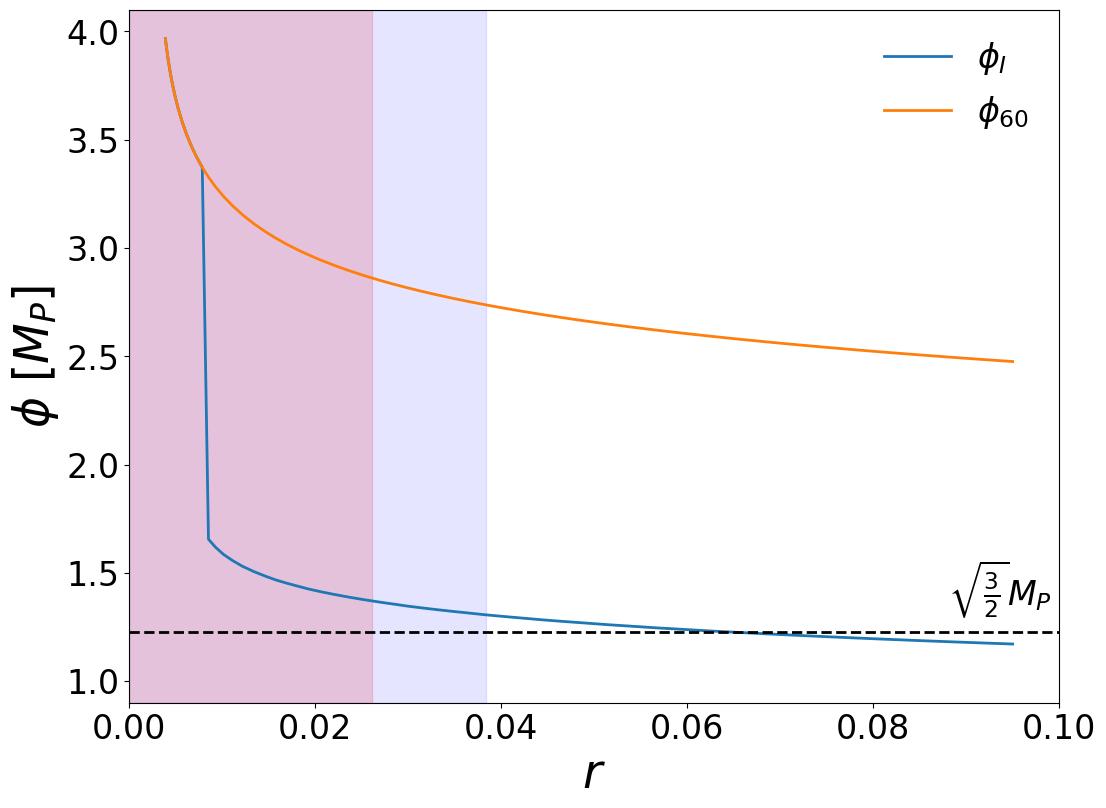

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
  'font.size': 24,
  'figure.figsize': (12, 9),
})

fig, ax = plt.subplots()
ax.axvspan(0, 0.0261, alpha=0.15, color='r')
ax.axvspan(0, 0.0383, alpha=0.1, color='b')

# r_plot_new=r_plot[30:39]
# phi_I_new=phi_I[30:39]
# phi_60_new=phi_60[30:39]
r_plot_new=r_plot
phi_I_new=phi_I
phi_60_new=phi_60

ax.plot(r_plot_new, phi_I_new, label='$\phi_{I}$', lw=2)
ax.plot(r_plot_new, phi_60_new, label='$\phi_{60}$', lw=2)
# ax.plot(r_plot, phi_I,marker=(5, 1),c='r')
# ax.plot(r_plot, phi_60,marker=(5, 1),c='r')

ax.axhline(y=np.sqrt(3.0/2.0), c='black', ls='--', lw=2)
ax.annotate('$\sqrt{\\frac{3}{2}}M_P$', xy=(0.088, 1.35))

ax.set_xlim(0.0, 0.10)
ax.set_ylim(0.9, 4.1)

ax.set_xlabel('$r$', fontsize=34)
ax.set_ylabel('$\phi \ [M_P]$', fontsize=34)

leg = plt.legend(frameon=False, loc=1)
leg.get_frame().set_alpha(0.5)
plt.savefig('inflection_pt.pdf', bbox_inches='tight')
plt.show()